In [3]:
import numpy as np
import pandas as pd
import duckdb
import glob
from rdkit import Chem

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Loading data

In [2]:
# # List of all excel files in the directory
# all_files = glob.glob("/Users/sethhowes/Desktop/FS-Tox/data/raw/toxvaldb/*.xlsx")

# # Empty list to hold dataframes
# df_list = []

# # Loop through all files
# for file in all_files:
#     # Read each excel file as a pandas dataframe
#     df = pd.read_excel(file)
#     # Append the dataframe to the list
#     df_list.append(df)

# # Concatenate all dataframes in the list
# tox_df = pd.concat(df_list, ignore_index=True)

In [3]:
# # Output as csv to reduce loading time
# tox_df.to_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/toxvaldb.csv")

In [6]:
tox_df = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/toxvaldb_2023.csv")

/var/folders/t1/p54ybn1n4j3_ywd21t7skv2m0000gn/T/ipykernel_49069/4011756987.py:1: DtypeWarning: Columns (23,49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  tox_df = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/raw/toxvaldb_2023.csv")


# Cleaning data

In [7]:
tox_df.shape

(905858, 69)

In [8]:
tox_df.head()

Unnamed: 0         dtxsid      casrn     name         source subsource   
0           0  DTXSID8020090    62-53-3  Aniline  Health Canada         -  \
1           1  DTXSID4023886  7440-38-2  Arsenic  Health Canada         -   
2           2  DTXSID4023886  7440-38-2  Arsenic  Health Canada         -   
3           3  DTXSID4023886  7440-38-2  Arsenic  Health Canada         -   
4           4  DTXSID8023894  7440-39-3   Barium  Health Canada         -   

  qc_status risk_assessment_class     human_eco          toxval_type   
0      pass               chronic  human health                  TDI  \
1      pass               chronic  human health  cancer slope factor   
2      pass               chronic  human health  cancer slope factor   
3      pass               chronic  human health     cancer unit risk   
4      pass               chronic  human health                  TDI   

  toxval_type_original toxval_subtype toxval_type_supercategory   
0             oral TDI              -            Exposure Limit  \
1              oral SF              -            Toxicity Value   
2        inhalation SF              -            Toxicity Value   
3        inhalation UR              -            Toxicity Value   
4             oral TDI              -            Exposure Limit   

  toxval_numeric_qualifier  toxval_numeric   toxval_units   
0                        =          0.0072      mg/kg-day  \
1                        =          1.8000  (mg/kg-day)-1   
2                        =         27.0000  (mg/kg-day)-1   
3                        =          6.4000      (mg/m3)-1   
4                        =          0.2000      mg/kg-day   

   toxval_numeric_original toxval_units_original study_type   
0                   0.0072               mg/kg-d          -  \
1                   1.8000           (mg/kg-d)-1    chronic   
2                  27.0000           (mg/kg-d)-1    chronic   
3                   6.4000             (mg/m3)-1    chronic   
4                   0.2000               mg/kg-d          -   

  study_type_original study_duration_class   
0                   -              chronic  \
1                   -         epidemiology   
2                   -         epidemiology   
3                   -         epidemiology   
4                   -              chronic   

                     study_duration_class_original  study_duration_value   
0                                          chronic                 104.0  \
1               epidemiological (natural exposure)                  60.0   
2  epidemiological (occupationally exposed cohort)                -999.0   
3  epidemiological (occupationally exposed cohort)                -999.0   
4                                          chronic                   2.0   

  study_duration_value_original study_duration_units   
0                         104.0                weeks  \
1                          60.0                years   
2                           0.0                    -   
3                           0.0                    -   
4                           2.0                years   

  study_duration_units_original  species_id species_original common_name   
0                         weeks        4510             rats         Rat  \
1                         years     2000000            human       Human   
2                             -     2000000            human       Human   
3                             -     2000000            human       Human   
4                         years     3000042    rats and mice  Mouse, Rat   

          latin_name ecotox_group habitat strain strain_group strain_original   
0  Rattus norvegicus      Mammals       -      -            -               -  \
1       Homo sapiens      Mammals       -      -            -               -   
2       Homo sapiens      Mammals       -      -            -               -   
3       Homo sapiens      Mammals       -      -            -               -   
4         Mouse, Rat     

In [9]:
tox_df.columns

Index(['Unnamed: 0', 'dtxsid', 'casrn', 'name', 'source', 'subsource',
       'qc_status', 'risk_assessment_class', 'human_eco', 'toxval_type',
       'toxval_type_original', 'toxval_subtype', 'toxval_type_supercategory',
       'toxval_numeric_qualifier', 'toxval_numeric', 'toxval_units',
       'toxval_numeric_original', 'toxval_units_original', 'study_type',
       'study_type_original', 'study_duration_class',
       'study_duration_class_original', 'study_duration_value',
       'study_duration_value_original', 'study_duration_units',
       'study_duration_units_original', 'species_id', 'species_original',
       'common_name', 'latin_name', 'ecotox_group', 'habitat', 'strain',
       'strain_group', 'strain_original', 'sex', 'sex_original', 'generation',
       'lifestage', 'exposure_route', 'exposure_route_original',
       'exposure_method', 'exposure_method_original', 'exposure_form',
       'exposure_form_original', 'media', 'media_original', 'critical_effect',
       'criti

I want to remove those rows which have NA values for our key variables:
- `dtxsid` AND `casrn` AND `name`
- `toxval_type`
- `common_name`
- `exposure_route`
- `toxval_units`
- `study_type`
- `source`
- `toxval_numeric`

NaN values are represented as "-" in the dataframe, so I must convert them.

In [10]:
tox_df.replace('-', np.nan, inplace=True)

Now let's assess missingness for our key variables.

In [17]:
key_vars = ["toxval_type", "common_name", "exposure_route", "toxval_units", "study_type", "source", "toxval_numeric", "long_ref"]

In [18]:
tox_df[key_vars].isna().sum()

toxval_type       0
common_name       0
exposure_route    0
toxval_units      0
study_type        0
source            0
toxval_numeric    0
long_ref          0
dtype: int64

I will now remove all records where there is missingness for this data

In [15]:
tox_df = tox_df.dropna(subset=key_vars)

In [19]:
tox_df.shape

(718145, 69)

I also want to check whether there is any missingness for the chemical identifiers. However, I only want to remove those rows where is no value for all three of the chemical identifier variables.

In [20]:
identifier_list = ["dtxsid", "casrn", "name"]
tox_df[identifier_list].isna().sum()

dtxsid        0
casrn     14359
name          0
dtype: int64

Each record has a dtxsid, meaning that I don't have to remove any records.

# Mapping molecule IDs to canonical SMILES

There are several small molecule identifiers that are present in our dataset. These are:
- `dtxsid` - DSSTox generic substance ID
- `casrn` - Chemical Abstracts Registry Number
- `name` - DSSTox preferred clinical name
- `chemical_id` - primary key in the `source_chemical` table

There are several ways to approach the converstion to canonical SMILES. Unfortunately neither RDKit nor Open Babel provide a function for mapping from the identifiers above to SMILES directly.

In [21]:
# Load idenitifiers
identifiers = pd.read_csv("/Users/sethhowes/Desktop/FS-Tox/data/external/DSSTox_Identifiers_and_CASRN_2021r1.csv")

In [22]:
identifiers.head()

dtxsid           dtxcid       casrn   
0  DTXSID001000007  DTXCID101426975  78774-48-8  \
1  DTXSID001000019  DTXCID101426987  78782-46-4   
2  DTXSID001000021  DTXCID501426989  78793-09-6   
3  DTXSID001000033  DTXCID001427001  78806-60-7   
4  DTXSID001000045  DTXCID001427013  78807-76-8   

                                       preferredName   
0                  5-(Dimethylsulfaniumyl)pentanoate  \
1                   3,5-Dichloro-2,6-dimethoxyphenol   
2  N-(2-Aminoethyl)-3,7,12-trihydroxycholan-24-im...   
3  2-(5-Hydroxy-4a,6a,8,8-tetramethyl-2-oxo-2,4a,...   
4  2-[3-(4-Chlorophenyl)-5-(2-nitrophenyl)-4,5-di...   

                                               inchi   
0  InChI=1S/C7H14O2S/c1-10(2)6-4-3-5-7(8)9/h3-6H2...  \
1  InChI=1S/C8H8Cl2O3/c1-12-7-4(9)3-5(10)8(13-2)6...   
2  InChI=1S/C26H46N2O4/c1-15(4-7-23(32)28-11-10-2...   
3  InChI=1S/C28H38O7/c1-6-7-23(32)33-15-21(31)28-...   
4  InChI=1S/C29H21ClN4O3S/c30-20-15-13-19(14-16-2...   

                      inchiKey  
0  XWVBBNDMCIQEJS-UHFFFAOYSA-N  
1  IDKMFABKPPHDBI-UHFFFAOYSA-N  
2  KEMCGGSAAWVSIG-HZAMXZRMSA-N  
3  UWWXLWUUTASPBC-SSAOTNNDSA-N  
4  LOZQWNUKZJWQOV-UHFFFAOYSA-N

In [23]:
# Join assay_df and csv with chemical identifiers
tox_with_inchis = tox_df.merge(identifiers, how="left", on="dtxsid")

I want to check what percentage of records have been successfully associated with an InChI.

In [24]:
num_missing = tox_with_inchis["inchi"].isna().sum()
prop_missing = num_missing / len(tox_with_inchis)
print(f"{prop_missing:.2f} proportion of records still need resolving")

0.13 proportion of records still need resolving


I will now map available InChIs to canonical SMILES.

In [25]:
# Define a function to convert InChI to SMILES
def convert_to_smiles(inchi):
    mol = Chem.MolFromInchi(inchi)
    if mol is None:
        return 'InvalidInChI'  # Placeholder for invalid InChI
    smiles = Chem.MolToSmiles(mol)
    return smiles


# Apply the function to each value in the Series
smiles_series = tox_with_inchis["inchi"].astype(str).apply(convert_to_smiles)

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 

[11:08:26] ERROR: 



In [45]:
smiles_series.value_counts()

inchi
InvalidInChI                                                                              92750
O=S(=O)([O-])[O-].[Cu+2]                                                                  16746
[Cd+2].[Cl-].[Cl-]                                                                         7647
CCN=c1nc(Cl)[nH]c(=NC(C)C)[nH]1                                                            6835
CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl                                                           5989
                                                                                          ...  
C=CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC(C)C)C1c1cccc(C(F)(F)F)c1                                     1
CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCCOC)C1c1ccccc1Cl                                                1
C#CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1OC                                                 1
COC(=O)[C@H](Cc1ccc(CC(=O)O)c(CC(=O)O)c1)N=C(O)[C@@H](N)Cc1ccc(CC(=O)O)c(CC(=O)O)c1.Cl        1
C[N+](C)(C)CCCl                   

In [48]:
smiles_series.isna().sum()

0

In [49]:
# Reset index to ensure they merge properly
tox_df = tox_df.reset_index(drop=True)
tox_df["smiles"] = smiles_series

In [29]:
# Drop rows where smiles column is equal to 'InvalidInChI'
tox_df = tox_df[tox_df['smiles'] != 'InvalidInChI']

In [30]:
len(tox_df)

625395

In [31]:
tox_df.shape

(625395, 70)

In [32]:
tox_df["smiles"].isna().sum()

0

In [25]:
tox_df.head()

Unnamed: 0         dtxsid      casrn     name         source subsource   
0           1  DTXSID4023886  7440-38-2  Arsenic  Health Canada       NaN  \
1           2  DTXSID4023886  7440-38-2  Arsenic  Health Canada       NaN   
2           3  DTXSID4023886  7440-38-2  Arsenic  Health Canada       NaN   
3           5  DTXSID3039242    71-43-2  Benzene  Health Canada       NaN   
4           6  DTXSID3039242    71-43-2  Benzene  Health Canada       NaN   

  qc_status risk_assessment_class     human_eco          toxval_type  ...   
0      pass               chronic  human health  cancer slope factor  ...  \
1      pass               chronic  human health  cancer slope factor  ...   
2      pass               chronic  human health     cancer unit risk  ...   
3      pass               chronic  human health  cancer slope factor  ...   
4      pass               chronic  human health  cancer slope factor  ...   

  toxval_type_category  source_url  subsource_url toxval_id   
0         Slope Factor  source_url  subsource_url    159933  \
1         Slope Factor  source_url  subsource_url    159934   
2            Unit Risk  source_url  subsource_url    159935   
3         Slope Factor  source_url  subsource_url    159937   
4         Slope Factor  source_url  subsource_url    159938   

                        source_hash          source_table   
0  fe7d52d99b4f4a010dd9761914b9f858  source_health_canada  \
1  42e239b39fe4dcf25a0bbfed4788598a  source_health_canada   
2  6307ec8f8d0f8b1f1022dcd07a37830c  source_health_canada   
3  cb4c7d5f15af315c82030761c442b405  source_health_canada   
4  fd0d3ea5d2b371a97bbdd7bd0e315bf2  source_health_canada   

            details_text                   chemical_id priority_id    smiles  
0  Health Canada Details  ToxVal00016_f6551400ba3b7911           3      [As]  
1  Health Canada Details  ToxVal00016_f6551400ba3b7911           3      [As]  
2  Health Canada Details  ToxVal00016_f6551400ba3b7911           3      [As]  
3  Health Canada Details  ToxVal00016_2c6b4dd14d0c0038           3  c1ccccc1  
4  Health Canada Details  ToxVal00016_2c6b4dd14d0c0038           3  c1ccccc1  

[5 rows x 70 columns]

# Creating assays
I want to create individual assays from all available data. Each assay will be a grouping of characteristics that would be used to identify an assays. The relevant features that are sufficient to identify an assay are:
- `common_name` - species
- `source` - dataset the record originated from
- `toxval_type` - outcome score type
- `toxval_units` - units for measuring exposure
- `study_type` - basic description of assay
- `exposure_route` - route of administration

In [33]:
assay_components = ['common_name', 'source', 'toxval_type', 'toxval_units', 'study_type', 'exposure_route', 'long_ref']
assays = tox_df.groupby(assay_components).size().reset_index(name='counts')

In [34]:
assays.head()

common_name  source toxval_type toxval_units study_type   
0  4-Spine Stickleback  ECOTOX        LC50        mg/m3  mortality  \
1  4-Spine Stickleback  ECOTOX        LC50        mg/m3  mortality   
2  4-Spine Stickleback  ECOTOX        LC50        mg/m3  mortality   
3  4-Spine Stickleback  ECOTOX        LC50        mg/m3  mortality   
4  4-Spine Stickleback  ECOTOX        LC50        mg/m3  mortality   

  exposure_route                                           long_ref  counts  
0        aqueous  Letter to D.Hansen, U.S.EPA, Narragansett, RI:...       1  
1        aqueous  Memo from J.A.Cardin to D.Hansen:6 p. Cardin,J...       1  
2        aqueous  Memo to J.H.Gentile, U.S.EPA, Narragansett, RI...       1  
3        aqueous  U.S.EPA, Narragansett, RI:14 p. Lussier,S.M., ...       1  
4        aqueous  U.S.EPA, Narragansett, RI:2 p. Cardin,J.A. Res...       1

In [35]:
len(assays)

144607

It appears that there is missingness in the exposure route column. I will now quantify the missingness.

I now want to plot the distribution of the size of each assay.

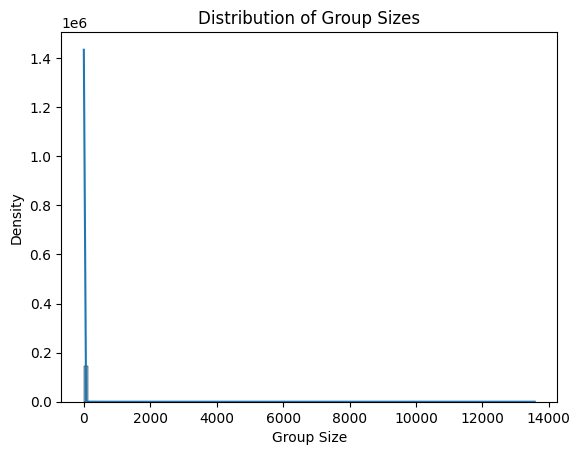

In [36]:
# Create a histogram/density plot
sns.histplot(assays['counts'], bins=100, kde=True)

plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Density')
plt.show()

We can see there is a very long right tail but the vast majority of assays have few records.

In [37]:
# Get the median assay size
assays["counts"].median()

2.0

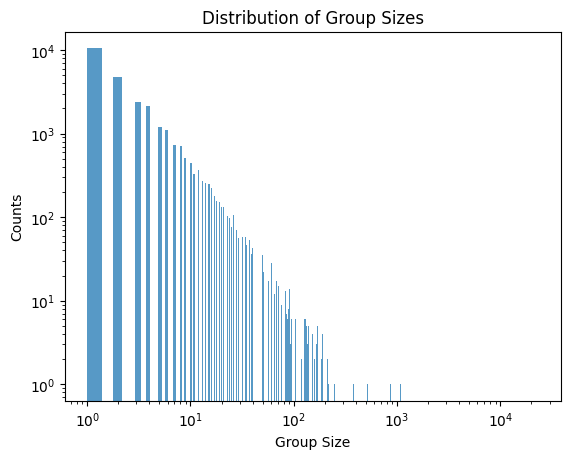

In [33]:
# Create a histogram/density plot
sns.histplot(assays['counts'])

plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Counts')

# Log scale the y-axis
plt.yscale('log')

# Log scale the x-axis
plt.xscale('log')

plt.show()

We can see here that there is an exponential decrease in the size of assays

I want to explore why there is such a long right tail of the distribution.

In [38]:
assays["source"].value_counts()

source
ECOTOX                            78730
ChemIDplus                        19416
ToxRefDB                          14098
ECHA IUCLID                       10595
TEST                               6691
HPVIS                              3889
EFSA                               3226
COSMOS                             3162
EFSA2                              1284
Wignall                             775
PPRTV (NCEA)                        588
HAWC Project                        377
Uterotrophic Hershberger DB         332
ATSDR PFAS 2021                     315
WHO IPCS                            241
PPRTV (CPHEA)                       227
ATSDR PFAS                          195
HAWC PFAS 150                       121
PFAS 150 SEM v2                     108
HAWC PFAS 430                        85
Chiu                                 59
Copper Manufacturers                 52
Health Canada                        29
DOD                                   6
DOE Protective Action Criteria   

In [39]:
assays[assays["counts"] < 24].sort_values(by="counts", ascending=False).head(20)

common_name      source toxval_type toxval_units     study_type   
13146             Ciliate      ECOTOX        NOEC        mg/m3   biochemistry  \
9777             Bullfrog      ECOTOX        LOEC        mg/m3     physiology   
34736               Guaru      ECOTOX        LC50        mg/m3      mortality   
52078               Mouse  ChemIDplus        LD50        mg/kg          acute   
111132                Rat    ToxRefDB         LEL    mg/kg-day   reproduction   
130619         Water Flea      ECOTOX        EC50        mg/m3   reproduction   
77271       Rainbow Trout      ECOTOX        LC50        mg/m3      mortality   
118758  Rice Water Weevil      ECOTOX        LOEC         g/m2     population   
9223         Brown Shrimp      ECOTOX        EC50        mg/m3       multiple   
9224         Brown Shrimp      ECOTOX        EC50        mg/m3       multiple   
52358               Mouse  ChemIDplus        LD50        mg/kg          acute   
130268         Water Flea      ECOTOX        EC50        mg/m3  neurotoxicity   
85204                 Rat  ChemIDplus        LD50        mg/kg          acute   
130267         Water Flea      ECOTOX        EC50        mg/m3  neurotoxicity   
121125               Scud      ECOTOX        LC50        mg/m3      mortality   
121113               Scud      ECOTOX        LC50        mg/m3      mortality   
143435        Zebra Danio      ECOTOX        NOEC        mg/m3      mortality   
66448       Northern Pike      ECOTOX        LC50        mg/m3      mortality   
77206       Rainbow Trout      ECOTOX        LC50        mg/m3      mortality   
138722        Zebra Danio      ECOTOX        EC20        mg/m3       genetics   

       exposure_route                                           long_ref   
13146         aqueous  Protoplasma198(3-4): 143-154 Abraham,J.V., R.D...  \
9777         in vitro  J. Endocrinol.183(3): 627-637 Shimada,N., and ...   
34736         aqueous  Fresenius Environ. Bull.7(11/12): 654-658 Da S...   
52078            oral  European Journal of Medicinal Chemistry--Chimi...   
111132           oral  toxrefdb study_id:3605 citation: Milburn, G. (...   
130619        aqueous  Environ. Toxicol. Chem.27(10): 2097-2107 Delee...   
77271         aqueous  Bull. Environ. Contam. Toxicol.36(3): 468-474 ...   
118758        aqueous  Arthropod Manag. Tests24:277-278 Way,M.O., and...   
9223          aqueous  Fish and Wildlife Service, Circular 167, Washi...   
9224          aqueous  In: Circular 226, Effects of Pesticides on Fis...   
52358            oral  Farmaco, Edizione Scientifica. Vol. 38, Pg. 84...   
130268        aqueous  Environ. Toxicol. Chem.25(8): 2221-2226 Oh,S.J...   
85204          dermal  Toxicology and Applied Pharmacology. Vol. 14, ...   
130267        aqueous  Environ. Toxicol. Chem.25(7): 1831-1835 Kolts,...   
121125        aqueous  C. R. Hebd. Seances Acad. Sci. Ser. D Sci. Nat...   
121113        aqueous  Bull. Environ. Contam. Toxicol.59(6): 963-967 ...   
143435        aqueous  Environ. Sci. Technol.47(9): 4726-4733 Bar-Ila...   
66448         aqueous  USDI Fish and Wildlife Service, Publication No...   
77206         aqueous  Aquat. Toxicol.1(2): 129-142 Van der Putte,I.,...   
138722        aqueous  Chemosphere245:10 p. Wang,P., Z. Wang, P. Xia,...   

        counts  
13146       23  
9777        23  
34736       23  
52078       23  
111132      23  
130619      23  
77271       23  
118758      23  
9223        23  
9224        23  
52358       23  
130268      23  
85204       23  
130267      23  
121125      23  
121113      23  
143435      23  
66448       23  
77206       23  
138722      23

We can see that those assays for which we would expect there to be a large number of compounds (acute oral toxicity in a rat) are well represented in this list of assays.

We are defining our threshold for compounds per assay at 24. FS-Mol has a minimum assay size of 32, but at this threshold we reduce the number of tasks significant. We can see the difference in numbers of assays at these two different thresholds below.

In [40]:
lower_threshold = (assays["counts"] > 24).sum()
higher_threshold = (assays["counts"] > 32).sum()
print(f"{lower_threshold} assays at a threshold of 24 compounds per assay")
print(f"{higher_threshold} assays at a threshold of 32 compounds per assay")

2604 assays at a threshold of 24 compounds per assay
1679 assays at a threshold of 32 compounds per assay


I want my final assay set to be those assays with 24 records or more.

In [54]:
final_assays = assays[assays["counts"] > 24]

I also want to assess which sources the assays come from.

In [79]:
final_assays["source"].value_counts()

source
ECOTOX                            2092
ECHA IUCLID                        223
ToxRefDB                            69
HPVIS                               39
EFSA                                36
COSMOS                              34
ChemIDplus                          16
HAWC PFAS 150                       16
Uterotrophic Hershberger DB         14
PPRTV (NCEA)                        13
HAWC Project                        13
DOE Wildlife Benchmarks             12
ATSDR MRLs 2022                     12
HESS                                10
ATSDR MRLs 2020                     10
HAWC PFAS 430                        9
Alaska DEC                           9
ATSDR PFAS                           9
PPRTV (ORNL)                         9
ATSDR PFAS 2021                      9
EFSA2                                8
IRIS                                 8
Wignall                              8
Cal OEHHA                            8
DOE Protective Action Criteria       6
DOD               

# Unique molecules
I now want to check the number of unique molecules that I have in this dataset

In [2]:
# Get records where the order of magnitude range of the assay outcomes is greater than 2 
assay_df = assay_df.groupby(assay_components).filter(lambda x: (max(x) - min(x)) >= 2)

NameError: name 'assay_df' is not defined

In [81]:
# Remove unecessary column
assay_df.drop("Unnamed: 0", axis=1, inplace=True)

In [82]:
len(assay_df["dtxsid"].unique())

40461

# Deep dive

In order to get a better understanding of our component assays, I will study three assays separately. I will choose one small assay, one medium assay, and one larger assay.

In [61]:
print(f"Largest assay size: {max(final_assays['counts'])}")
print(f"Smallest assay size: {min(final_assays['counts'])}")

Largest assay size: 23240
Smallest assay size: 25


I will do a deep dive into assays of different sizes:
- small (25) - Mouse, ATSDR PFAS, LOAEL, mg/kg-day, subchronic, oral
- mid-ranged (1090) - Zebra Danio, ECOTOX, NOEC, mg/m3, neurotoxicity, aqueous
- largest (23240) - Mouse, ChemIDplus, LD50, mg/kg, acute, oral

## Deep dive 1 - small

In [85]:
small_assay = assay_df[(assay_df['common_name'] == 'Mouse') &
                 (assay_df['source'] == 'ATSDR PFAS') &
                 (assay_df['toxval_type'] == 'LOAEL') &
                 (assay_df['toxval_units'] == 'mg/kg-day') &
                 (assay_df['study_type'] == 'subchronic') &
                 (assay_df['exposure_route'] == 'oral')]


In [87]:
small_assay.head(25)

dtxsid      casrn                                name   
66060  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate  \
66061  DTXSID8031865   335-67-1              Perfluorooctanoic acid   
66065  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66069  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66078  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66079  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66080  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66083  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66084  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66085  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66086  DTXSID8031865   335-67-1              Perfluorooctanoic acid   
66087  DTXSID8031865   335-67-1              Perfluorooctanoic acid   
66089  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66090  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66091  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66122  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66126  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66127  DTXSID8031865   335-67-1              Perfluorooctanoic acid   
66128  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66129  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66130  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66131  DTXSID8037708  3825-26-1         Ammonium perfluorooctanoate   
66279  DTXSID8037706  2795-39-3  Potassium perfluorooctanesulfonate   
66280  DTXSID8037706  2795-39-3  Potassium perfluorooctanesulfonate   
66285  DTXSID3031864  1763-23-1        Perfluorooctanesulfonic acid   

           source        subsource qc_status risk_assessment_class   
66060  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic  \
66061  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66065  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66069  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66078  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66079  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66080  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66083  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66084  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66085  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66086  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66087  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66089  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66090  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66091  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66122  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66126  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66127  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66128  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66129  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66130  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66131  ATSDR PFAS  ATSDR PFOA Oral      pass            subchronic   
66279  ATSDR PFAS  ATSDR PFOS Oral      pass            subchronic   
66280  ATSDR PFAS  ATSDR PFOS Oral      pass            subchronic   
66285  ATSDR PFAS  ATSDR PFOS Oral      pass            subchronic   

          human_eco toxval_type toxval_type_original toxval_subtype   
66060  human health       LOAEL   LOAEL_less_serious            NaN  \
66061  human health       LOAEL   LOAEL_less_serious            NaN   
66065  human health       LOAEL   LOAEL_less_serious            NaN   
66069  human health       LOAEL   LOAEL_less_serious          

The source of this data (ASTDR PFAS) is a governmental agency responsible for assessing the role of per- and polyfluoroalkyl substances (PFAS). These are man-made chemicals that have been widely used in industry and consumer products since the 1940s and remain in the environment for a long time.

It appears that there are multiple records for the same compound (ammonium perfluorooctanoate). I want to see how many unique compounds there are in this dataset.

In [88]:
small_assay['name'].unique()

array(['Ammonium perfluorooctanoate', 'Perfluorooctanoic acid',
       'Potassium perfluorooctanesulfonate',
       'Perfluorooctanesulfonic acid'], dtype=object)

In [89]:
small_assay['name'].value_counts()

name
Ammonium perfluorooctanoate           18
Perfluorooctanoic acid                 4
Potassium perfluorooctanesulfonate     2
Perfluorooctanesulfonic acid           1
Name: count, dtype: int64

It appears that there are only 4 compounds studied in this assay. I want to see how much the target value varies for a given compound.

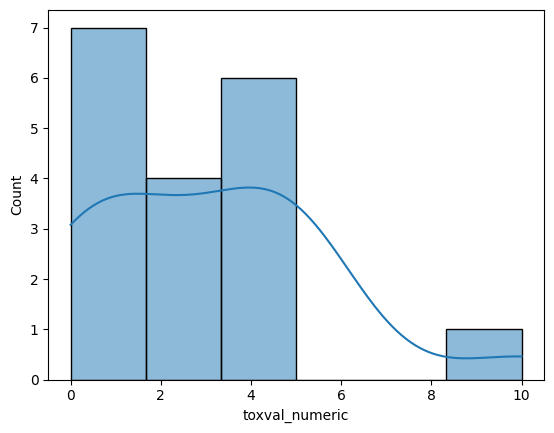

In [91]:
ammon_per = small_assay[small_assay['name'] == "Ammonium perfluorooctanoate"]
sns.histplot(data=ammon_per, x='toxval_numeric', kde=True)
plt.show()

I will now plot the distributions of each compound on the same plot.

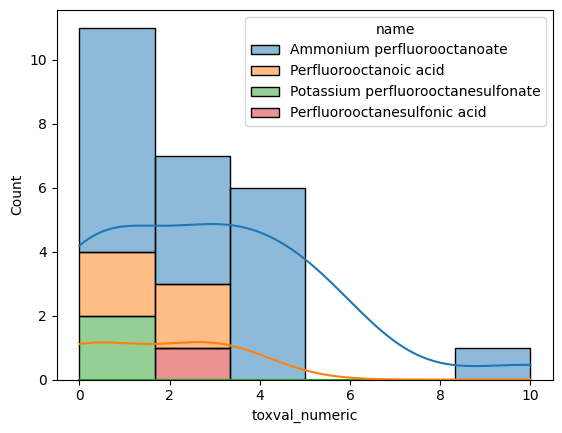

In [95]:
sns.histplot(data=small_assay, x='toxval_numeric', hue='name', multiple='stack', kde=True)
plt.show()

In [100]:
small_assay.groupby("name")["toxval_numeric"].agg(["mean", "std"])

mean       std
name                                                  
Ammonium perfluorooctanoate         3.089556  2.629513
Perfluorooctanesulfonic acid        2.150000       NaN
Perfluorooctanoic acid              1.577500  1.646823
Potassium perfluorooctanesulfonate  0.083150  0.000212

I also want to see whether these compounds were all sourced from the same set of experiments. This can be determined by assessing the references associated with each record.

In [102]:
small_assay["long_ref"].value_counts()

long_ref
Lau et al. 2006         4
White et al. 2011b      4
Wolf et al. 2007        3
Abbott et al. 2007      2
Albrecht et al. 2013    2
White et al. 2007       2
Hines et al. 2009       2
Macon et al. 2011       2
White et al. 2009       1
Dong et al. 2009        1
Dong et al. 2011        1
Long et al. 2013        1
Name: count, dtype: int64

The records included here come from a variety of different experimental procedures.

The experiment type here is LOEL, but I want to assess what each experiment was actually studying. This information is contained in the `critical_effect` column.

In [106]:
small_assay[["critical_effect", "long_ref"]]

critical_effect              long_ref
66060  hepatic: increased absolute and relative liver...    Abbott et al. 2007
66061  hepatic: increased liver weight, hepatocellula...  Albrecht et al. 2013
66065           hepatic: increased absolute liver weight       Lau et al. 2006
66069  hepatic: increased relative and absolute mater...      Wolf et al. 2007
66078  reproductive: delayed mammary gland differenti...     White et al. 2007
66079  reproductive: delayed mammary gland lactationa...    White et al. 2011b
66080  reproductive: delayed mammary gland lactationa...    White et al. 2011b
66083                                      developmental     Hines et al. 2009
66084     developmental: increased postnatal body weight     Hines et al. 2009
66085           developmental: lower body weight of pups       Lau et al. 2006
66086  developmental: impaired development of mammary...     Macon et al. 2011
66087  developmental: developmental delays in mammary...     Macon et al. 2011
66089  developmental: delayed mammary gland developme...     White et al. 2009
66090  developmental: delayed mammary gland developme...    White et al. 2011b
66091  delayed eye opening and hair growth)|developme...      Wolf et al. 2007
66122                              body weight reduction       Lau et al. 2006
66126  developmental: reduced pups survival from birt...    Abbott et al. 2007
66127             developmental: reduced pups per litter  Albrecht et al. 2013
66128   developmental: increased full litter resorptions       Lau et al. 2006
66129  40% reduced neonatal body weight on pnd 5 and ...     White et al. 2007
66130  developmental: increased prenatal loss, reduce...    White et al. 2011b
66131  developmental: reduced pup survival from birth...      Wolf et al. 2007
66279  immunological/lymphoreticular: impaired respon...      Dong et al. 2009
66280  immunological/lymphoreticular: impaired respon...      Dong et al. 2011
66285    neurological: impaired spatial learning, memory      Long et al. 2013

It is clear that there are a heterogenous set of adverse effects that are being assessed. The critical effects tends to be specific to the study, with there being some overlap (e.g. Macon et al. 2011 and White et al. 2009 both assessing impaired development of mammary glands as their endpoint).

## Deep dive 2

I will take a similar approach to this as I did for the previous assay assessment.

In [108]:
mid_assay = assay_df[(assay_df['common_name'] == 'Zebra Danio') &
                 (assay_df['source'] == 'ECOTOX') &
                 (assay_df['toxval_type'] == 'NOEC') &
                 (assay_df['toxval_units'] == 'mg/m3') &
                 (assay_df['study_type'] == 'neurotoxicity') &
                 (assay_df['exposure_route'] == 'aqueous')]

In [110]:
mid_assay.head(20)

dtxsid         casrn   
69660   DTXSID30892995   114519-85-6  \
69661   DTXSID30892995   114519-85-6   
89662    DTXSID1023940     7440-43-9   
89763    DTXSID1023940     7440-43-9   
89790    DTXSID1023940     7440-43-9   
89806    DTXSID1023940     7440-43-9   
89920    DTXSID1023940     7440-43-9   
89928    DTXSID1023940     7440-43-9   
90054    DTXSID1023940     7440-43-9   
90139    DTXSID1023940     7440-43-9   
90393    DTXSID1023940     7440-43-9   
90558    DTXSID1023940     7440-43-9   
90559    DTXSID1023940     7440-43-9   
90801    DTXSID1023940     7440-43-9   
90863    DTXSID1023940     7440-43-9   
91793  DTXSID001009916  2481740-05-8   
91795  DTXSID001009916  2481740-05-8   
91797  DTXSID301009915     2624-80-8   
91798  DTXSID301009915     2624-80-8   
91799  DTXSID701009917    23282-60-2   

                                                    name  source subsource   
69660    Sodium bis(1H,1H,2H,2H-perfluorodecyl)phosphate  ECOTOX   EPA ORD  \
69661    Sodium bis(1H,1H,2H,2H-perfluorodecyl)phosphate  ECOTOX   EPA ORD   
89662                                            Cadmium  ECOTOX   EPA ORD   
89763                                            Cadmium  ECOTOX   EPA ORD   
89790                                            Cadmium  ECOTOX   EPA ORD   
89806                                            Cadmium  ECOTOX   EPA ORD   
89920                                            Cadmium  ECOTOX   EPA ORD   
89928                                            Cadmium  ECOTOX   EPA ORD   
90054                                            Cadmium  ECOTOX   EPA ORD   
90139                                            Cadmium  ECOTOX   EPA ORD   
90393                                            Cadmium  ECOTOX   EPA ORD   
90558                                            Cadmium  ECOTOX   EPA ORD   
90559                                            Cadmium  ECOTOX   EPA ORD   
90801                                            Cadmium  ECOTOX   EPA ORD   
90863                                            Cadmium  ECOTOX   EPA ORD   
91793         Sodium 8-chloroperfluoro-1-octanesulfonate  ECOTOX   EPA ORD   
91795         Sodium 8-chloroperfluoro-1-octanesulfonate  ECOTOX   EPA ORD   
91797  Sodium mono(N-ethyl-2-perfluorooctylsulfonamin...  ECOTOX   EPA ORD   
91798  Sodium mono(N-ethyl-2-perfluorooctylsulfonamin...  ECOTOX   EPA ORD   
91799  Sodium bis[2-(N-ethylperfluorooctane-1-sulfona...  ECOTOX   EPA ORD   

      qc_status risk_assessment_class human_eco toxval_type   
69660      pass         neurotoxicity       eco        NOEC  \
69661      pass         neurotoxicity       eco        NOEC   
89662      pass         neurotoxicity       eco        NOEC   
89763      pass         neurotoxicity       eco        NOEC   
89790      pass         neurotoxicity       eco        NOEC   
89806      pass         neurotoxicity       eco        NOEC   
89920      pass         neurotoxicity       eco        NOEC   
89928      pass         neurotoxicity       eco        NOEC   
90054      pass         neurotoxicity       eco        NOEC   
90139      pass         neurotoxicity       eco        NOEC   
90393      pass         neurotoxicity       eco        NOEC   
90558      pass         neurotoxicity       eco        NOEC   
90559      pass         neurotoxicity       eco        NOEC   
90801      pass         neurotoxicity       eco        NOEC   
90863      pass         neurotoxicity       eco        NOEC   
91793      pass         neurotoxicity       eco        NOEC   
91795      pass         neurotoxicity       eco        NOEC   
91797      pass         neurotoxicity       eco        NOEC   
91798      pass         neurotoxicity       eco        NOEC   
91799      pass         neurotoxicity       eco        NOEC   

      toxval_type_original     toxval_subtype toxval_type_supercategory   
69660                 NOEC  active ingredient        Point of Departure  \
69661                 NOEC  active ingredient        Point of 

In [115]:
len(mid_assay['name'].unique())

246

246 unique compounds, meaning there are some compounds assessed more than once for this assay.

I will now check how many of these compounds have been assessed in multiple experiments.

In [131]:
mid_assay["name"].value_counts()

name
Chlorpyrifos                       43
Triphenyl phosphate                40
3,3',5,5'-Tetrabromobisphenol A    39
Bisphenol A                        39
Triadimefon                        30
                                   ..
Febantel                            1
2,2'-Bisphenol F                    1
Quipazine maleate                   1
Diisobutyl phthalate                1
Cadmium telluride                   1
Name: count, Length: 246, dtype: int64

I will check in greater deal what the variance is for experiments that have been repeated for individual compounds by getting the mean and standard deviation of `toxval_numeric` for the top 5 compounds listed in the cell above.

In [132]:
repeat_compounds = ["Chlorpyrifos", "Triphenyl phosphate", "3,3',5,5'-Tetrabromobisphenol A", "Bisphenol A", "Triadimefon"]

In [134]:
mid_assay_repeat_compounds = mid_assay[mid_assay["name"].isin(repeat_compounds)]
mid_assay_repeat_compounds.groupby("name")["toxval_numeric"].agg(["mean", "std"])

mean          std
name                                                      
3,3',5,5'-Tetrabromobisphenol A   2031.004413  5220.903511
Bisphenol A                       1271.712549  1384.191989
Chlorpyrifos                       252.037400   341.991754
Triadimefon                      10513.333333  7621.690162
Triphenyl phosphate               3112.963364  6833.944234

Slightly concerning how wide the outcome variation is for some of these compounds. Let's see if we can group experiments for "3,3',5,5'-Tetrabromobisphenol A" to the individual experiment level. I can do this by grouping by paper `title`.

In [138]:
mid_assay[mid_assay["name"] == "3,3',5,5'-Tetrabromobisphenol A"].groupby("title")["toxval_numeric"].agg(["size", "mean", "std"])

size          mean   
title                                                                    
Advanced Morphological - Behavioral Test Platfo...     6   1340.108000  \
Multidimensional In Vivo Hazard Assessment Usin...     1  33241.600000   
TBBPA Chronic Exposure Produces Sex-Specific Ne...     3     19.035660   
TBBPA Exposure During a Sensitive Developmental...     3   2719.380000   
Tetrabromobisphenol A Caused Neurodevelopmental...     3    116.666667   
Thyroid Disruption in Zebrafish (Danio rerio) L...     3    266.666667   
Toxicant Induced Behavioural Aberrations in Lar...     3    546.594710   
Toxicity Profiling of Flame Retardants in Zebra...    17   1583.640765   

                                                            std  
title                                                            
Advanced Morphological - Behavioral Test Platfo...  1662.605860  
Multidimensional In Vivo Hazard Assessment Usin...          NaN  
TBBPA Chronic Exposure Produces Sex-Specific Ne...    14.130313  
TBBPA Exposure During a Sensitive Developmental...     0.000000  
Tetrabromobisphenol A Caused Neurodevelopmental...    76.376262  
Thyroid Disruption in Zebrafish (Danio rerio) L...   115.470054  
Toxicant Induced Behavioural Aberrations in Lar...   466.299757  
Toxicity Profiling of Flame Retardants in Zebra...   197.864686

In [164]:
assay_df[assay_df["title"] == "Multidimensional In Vivo Hazard Assessment Using Zebrafish"]

dtxsid       casrn                    name  source subsource   
118882  DTXSID3020205     85-68-7  Benzyl butyl phthalate  ECOTOX   EPA ORD  \
118932  DTXSID3020205     85-68-7  Benzyl butyl phthalate  ECOTOX   EPA ORD   
119018  DTXSID3020205     85-68-7  Benzyl butyl phthalate  ECOTOX   EPA ORD   
119063  DTXSID3020205     85-68-7  Benzyl butyl phthalate  ECOTOX   EPA ORD   
119218  DTXSID3020205     85-68-7  Benzyl butyl phthalate  ECOTOX   EPA ORD   
...               ...         ...                     ...     ...       ...   
446441  DTXSID1022267  16752-77-5                Methomyl  ECOTOX   EPA ORD   
446511  DTXSID1022267  16752-77-5                Methomyl  ECOTOX   EPA ORD   
446518  DTXSID1022267  16752-77-5                Methomyl  ECOTOX   EPA ORD   
447038  DTXSID1022267  16752-77-5                Methomyl  ECOTOX   EPA ORD   
447056  DTXSID1022267  16752-77-5                Methomyl  ECOTOX   EPA ORD   

       qc_status risk_assessment_class human_eco toxval_type   
118882      pass                 other       eco        NOEC  \
118932      pass                 other       eco        NOEC   
119018      pass            morphology       eco        NOEC   
119063      pass                 other       eco        NOEC   
119218      pass         neurotoxicity       eco        NOEC   
...          ...                   ...       ...         ...   
446441      pass                growth       eco        NOEC   
446511      pass         neurotoxicity       eco        NOEC   
446518      pass            morphology       eco        LOEC   
447038      pass            morphology       eco        NOEC   
447056      pass                 other       eco        NOEC   

       toxval_type_original toxval_subtype toxval_type_supercategory   
118882                 NOEC    formulation        Point of Departure  \
118932                 NOEC    formulation        Point of Departure   
119018                 NOEC    formulation        Point of Departure   
119063                 NOEC    formulation        Point of Departure   
119218                 NOEC    formulation        Point of Departure   
...                     ...            ...                       ...   
446441                 NOEC    formulation        Point of Departure   
446511                 NOEC    formulation        Point of Departure   
446518                 LOEC    formulation        Point of Departure   
447038                 NOEC    formulation        Point of Departure   
447056                 NOEC    formulation        Point of Departure   

       toxval_numeric_qualifier  toxval_numeric toxval_units   
118882                        =       19991.400        mg/m3  \
118932                        =       19991.400        mg/m3   
119018                        =       19991.400        mg/m3   
119063                        =       19991.400        mg/m3   
119218                        =       19991.400        mg/m3   
...                         ...             ...          ...   
446441                        =       10381.200        mg/m3   
446511                        =       10381.200        mg/m3   
446518                        =       10381.200        mg/m3   
447038                        =         103.812        mg/m3   
447056                        =       10381.200        mg/m3   

        toxval_numeric_original toxval_units_original     study_type   
118882                19.991400                  mg/L     physiology  \
118932                19.991400                  mg/L     physiology   
119018                19.991400                  mg/L     morphology   
119063                19.991400                  mg/L      histology   
119218                19.991400                  mg/L  neurotoxicity   
...                         ...                   ...            ...   
446441                10.381200                  mg/L         growth   
446511                10.381200                  mg/L  neurotoxicity   
446518         

We can see that the mean outcome values for experiments span 4 orders of magnitude (19 --> 33241). This may be problematic, as it means that our assumption that individual assays are studying the same effect may be misplaced.

I will now look at the distribution of values for all compounds in this assay.

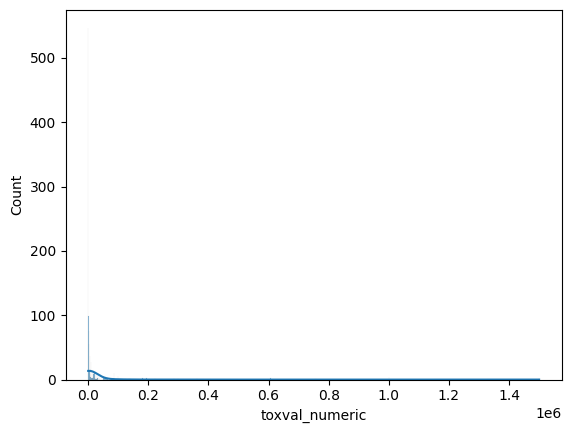

In [121]:
sns.histplot(data=mid_assay, x='toxval_numeric', kde=True)
plt.show()

Clearly there is a wide range of concentrations, so this would be better visualised as a ranked bar plot with the y-axis on the log scale.

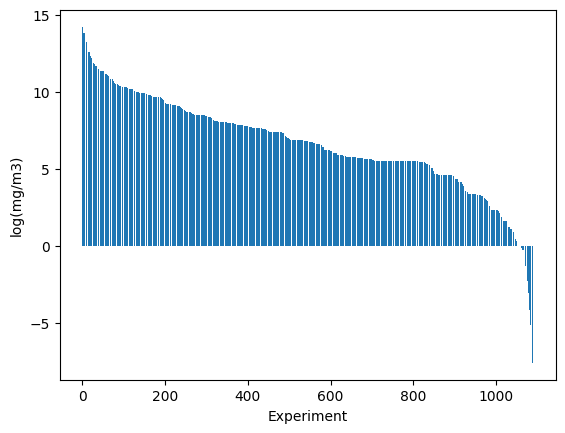

In [127]:
df_sorted = mid_assay.sort_values(by='toxval_numeric', ascending=False).reset_index()

plt.bar(df_sorted.index, np.log(df_sorted['toxval_numeric']))
plt.xlabel("Experiment")
plt.ylabel("log(mg/m3)")
plt.show()

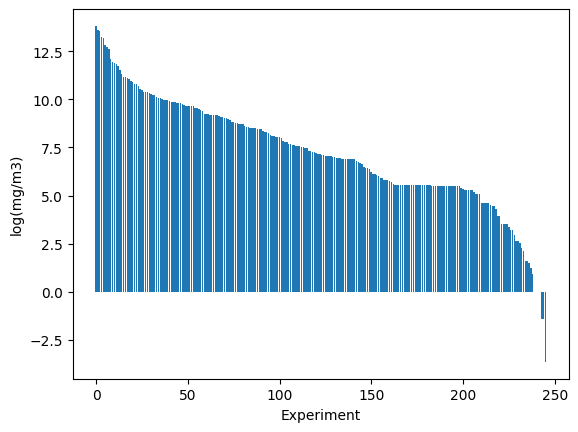

In [153]:
mid_assay_group = mid_assay.groupby("name")["toxval_numeric"].mean()

# Now 'mid_assay_group' is a Series, and you can sort it and then reset index
df_sorted = mid_assay_group.sort_values(ascending=False).reset_index()

# Now 'df_sorted' is a DataFrame with columns 'name' and 'toxval_numeric'
plt.bar(df_sorted.index, np.log(df_sorted['toxval_numeric']))
plt.xlabel("Experiment")
plt.ylabel("log(mg/m3)")
plt.show()


In [160]:
mid_assay_group.sort_values(ascending=False).tail(20)

name
Microcystin LF              25.000000
Microcystin RR              25.000000
Selenomethionine            19.610800
Deltamethrin                14.233333
Rotenone                    13.832733
Pentachlorophenol           12.500000
Lead(II) acetate             9.710000
Cadmium                      8.461538
Hexachloro-1,3-butadiene     5.000000
Mefenamic acid               5.000000
Ziram                        4.403438
Methimazole                  3.424950
Chlorpyrifos oxon            2.508925
Bisphenol B                  1.000000
Chlorantraniliprole          1.000000
Cypermethrin                 1.000000
Dinotefuran                  1.000000
Bis(tributyltin)oxide        0.243000
Cadmium telluride            0.240010
17beta-Trenbolone            0.026100
Name: toxval_numeric, dtype: float64

This better visualises the wide range of experimental doses covered as part of this assay.

## Deep dive 3

In [139]:
big_assay = assay_df[(assay_df['common_name'] == 'Mouse') &
                 (assay_df['source'] == 'ChemIDplus') &
                 (assay_df['toxval_type'] == 'LD50') &
                 (assay_df['toxval_units'] == 'mg/kg') &
                 (assay_df['study_type'] == 'acute') &
                 (assay_df['exposure_route'] == 'oral')]

In [140]:
big_assay.head(20)

dtxsid    casrn                         name      source   
480605  DTXSID7020637  50-00-0                 Formaldehyde  ChemIDplus  \
480610  DTXSID0022808  50-53-3               Chlorpromazine  ChemIDplus   
480615  DTXSID6025486  51-30-9  Isoproterenol hydrochloride  ChemIDplus   
480619  DTXSID8024652  52-51-7                     Bronopol  ChemIDplus   
480624  DTXSID0021389  52-68-6                  Trichlorfon  ChemIDplus   
480631  DTXSID8020620  55-38-9                     Fenthion  ChemIDplus   
480638  DTXSID1040667  55-91-4  Diisopropyl fluorophosphate  ChemIDplus   
480645  DTXSID0025440  56-18-8                Norspermidine  ChemIDplus   
480653  DTXSID8020250  56-23-5         Carbon tetrachloride  ChemIDplus   
480659  DTXSID9020166  56-35-9        Bis(tributyltin)oxide  ChemIDplus   
480667  DTXSID7021100  56-38-2                    Parathion  ChemIDplus   
480675  DTXSID2020347  56-72-4                    Coumaphos  ChemIDplus   
480682  DTXSID9020663  56-81-5                     Glycerol  ChemIDplus   
480690  DTXSID1020516  57-14-7        1,1-Dimethylhydrazine  ChemIDplus   
480696  DTXSID7020267  57-74-9                    Chlordane  ChemIDplus   
480703  DTXSID7020504  58-15-1    4-Dimethylaminoantipyrine  ChemIDplus   
480706  DTXSID9049324  59-49-4            2-Benzoxazolinone  ChemIDplus   
480709  DTXSID9026342  60-12-8              2-Phenylethanol  ChemIDplus   
480715  DTXSID4026343  60-24-2            2-Mercaptoethanol  ChemIDplus   
480724  DTXSID4020874  60-34-4              Methylhydrazine  ChemIDplus   

       subsource qc_status risk_assessment_class     human_eco toxval_type   
480605       NaN      pass                 acute  human health        LD50  \
480610       NaN      pass                 acute  human health        LD50   
480615       NaN      pass                 acute  human health        LD50   
480619       NaN      pass                 acute  human health        LD50   
480624       NaN      pass                 acute  human health        LD50   
480631       NaN      pass                 acute  human health        LD50   
480638       NaN      pass                 acute  human health        LD50   
480645       NaN      pass                 acute  human health        LD50   
480653       NaN      pass                 acute  human health        LD50   
480659       NaN      pass                 acute  human health        LD50   
480667       NaN      pass                 acute  human health        LD50   
480675       NaN      pass                 acute  human health        LD50   
480682       NaN      pass                 acute  human health        LD50   
480690       NaN      pass                 acute  human health        LD50   
480696       NaN      pass                 acute  human health        LD50   
480703       NaN      pass                 acute  human health        LD50   
480706       NaN      pass                 acute  human health        LD50   
480709       NaN      pass                 acute  human health        LD50   
480715       NaN      pass                 acute  human health        LD50   
480724       NaN      pass                 acute  human health        LD50   

       toxval_type_original toxval_subtype toxval_type_supercategory   
480605                 LD50            NaN    Lethality Effect Level  \
480610                 LD50            NaN    Lethality Effect Level   
480615                 LD50            NaN    Lethality Effect Level   
480619                 LD50            NaN    Lethality Effect Level   
480624                 LD50            NaN    Lethality Effect Level   
480631                 LD50            NaN    Lethality Effect Level   
480638                 LD50            NaN    Lethality Effect Level   
480645                 LD50            NaN    Lethality Effect Level   
480653                 LD50            NaN    Lethality Effect Level   
480659                 LD50            NaN    Lethality Effect Level   
480667  

In [143]:
len(big_assay['name'].unique())

23218

This indicates very few repeat assessments, as the total assay size is only slightly bigger (~24,000)

In [145]:
big_assay["name"].value_counts()

name
Polyethylene glycol                                                                     4
(2R,6S)-Fenpropimorph                                                                   3
Minocycline hydrochloride                                                               2
Albuterol sulfate                                                                       2
Ifosfamide                                                                              2
                                                                                       ..
Enfenamic acid                                                                          1
Terbutaline hemisulfate                                                                 1
3-Pyrrolinium, 1-(5-(3-pyrrolino)-2,4-pentadienylidene)-, perchlorate                   1
1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine hydrochloride                              1
5-Pyrimidinecarboxylic acid, 1,4-dihydro-4-oxo-2-((3-(trifluoromethyl)phenyl)amino)-    1
Name:

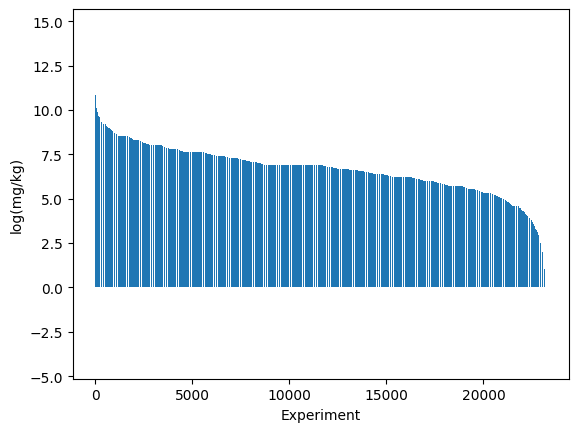

In [148]:
big_sorted = big_assay.sort_values(by='toxval_numeric', ascending=False).reset_index()

plt.bar(big_sorted.index, np.log(big_sorted['toxval_numeric']))
plt.xlabel("Experiment")
plt.ylabel("log(mg/kg)")
plt.show()

In [162]:
big_sorted.tail(20)

index           dtxsid        casrn   
23220  503894   DTXSID20945348   22683-22-3  \
23221  491130    DTXSID5042374     507-60-8   
23222  509125    DTXSID7052078   40321-76-4   
23223  497081   DTXSID10881342    4368-28-9   
23224  482260    DTXSID0039223     116-06-3   
23225  485520    DTXSID5032529   56073-10-0   
23226  488094    DTXSID6059158      98-05-5   
23227  507889   DTXSID60189042   35554-08-6   
23228  485218    DTXSID3074313   35523-89-8   
23229  505185   DTXSID30948805   25898-71-9   
23230  511870   DTXSID20971203   55803-45-7   
23231  494098    DTXSID2021315    1746-01-6   
23232  529112   DTXSID50202077     538-03-4   
23233  486734    DTXSID8024311      62-74-8   
23234  503952  DTXSID501030867   22791-12-4   
23235  501939   DTXSID40936990   16478-59-4   
23236  521325  DTXSID601027560   83805-11-2   
23237  527484    DTXSID1041057  130209-82-4   
23238  513863   DTXSID80977049   61481-19-4   
23239  490621    DTXSID7020558     316-42-7   

                                                    name      source   
23220  1-[(4,5-Dihydro-1H-imidazol-2-yl)methyl]-3-eth...  ChemIDplus  \
23221                                       Scilliroside  ChemIDplus   
23222              1,2,3,7,8-Pentachlorodibenzo-p-dioxin  ChemIDplus   
23223                                       Tetrodotoxin  ChemIDplus   
23224                                           Aldicarb  ChemIDplus   
23225                                        Brodifacoum  ChemIDplus   
23226                                Benzenearsonic acid  ChemIDplus   
23227                          Saxitoxin dihydrochloride  ChemIDplus   
23228                                          Saxitoxin  ChemIDplus   
23229   1-[(Dichloromethyl)(dimethyl)silyl]hex-1-yn-3-ol  ChemIDplus   
23230  4-Bromobenzene-1-sulfonic acid--(10,10-dihydro...  ChemIDplus   
23231                2,3,7,8-Tetrachlorodibenzo-p-dioxin  ChemIDplus   
23232                  Oxophenarsine hydrochloride [USP]  ChemIDplus   
23233                               Sodium fluoroacetate  ChemIDplus   
23234  2-(Methoxy(methylthio)phosphinylimino)-3-ethyl...  ChemIDplus   
23235  2,2'-([1,1'-Biphenyl]-4,4'-diyl)bis(2-hydroxy-...  ChemIDplus   
23236  (+)-(5Z,7E)-26,26,26,27,27,27-Hexafluoro-9,10-...  ChemIDplus   
23237                                        Latanoprost  ChemIDplus   
23238  4-tert-Butyl-2,6,7-trioxa-1-phosphabicyclo[2.2...  ChemIDplus   
23239                            Emetine dihydrochloride  ChemIDplus   

      subsource qc_status risk_assessment_class     human_eco toxval_type   
23220       NaN      pass                 acute  human health        LD50  \
23221       NaN      pass                 acute  human health        LD50   
23222       NaN      pass                 acute  human health        LD50   
23223       NaN      pass                 acute  human health        LD50   
23224       NaN      pass                 acute  human health        LD50   
23225       NaN      pass                 acute  human health        LD50   
23226       NaN      pass                 acute  human health        LD50   
23227       NaN      pass                 acute  human health        LD50   
23228       NaN      pass                 acute  human health        LD50   
23229       NaN      pass                 acute  human health        LD50   
23230       NaN      pass                 acute  human health        LD50   
23231       NaN      pass                 acute  human health        LD50   
23232       NaN      pass                 acute  human health        LD50   
23233       NaN      pass                 acute  human health        LD50   
23234       NaN      pass                 acute  human health        LD50   
23235       NaN      pass                 acute  human health        LD50   
23236       NaN      pass                 acute  human health        LD50   
23237       NaN      pass                 acute  human health        LD50   
23238       NaN      pass                 ac

Individual experiments span 10 orders of magnitude. 

In [163]:
assay_df['toxval_numeric_qualifier'].value_counts()

toxval_numeric_qualifier
=        437427
>         57531
>=         9677
<          7580
~          6594
<=          449
>= <=         3
Name: count, dtype: int64

# Grouping by title

I want to check what happens if we also group by long_ref, to try and resolve some of the problems we were having previously with large intra-assay heterogeneity.

In [219]:
# Remove those records without a long_ref
df_with_ref = tox_df[tox_df["long_ref"].notna()]

# Remove those records with toxval_numeric_qualifier not equal to "="
df_with_ref = df_with_ref[df_with_ref['toxval_numeric_qualifier'] != "="]

assay_components = ['common_name', 'source', 'toxval_type', 'toxval_units', 'study_type', 'exposure_route', 'long_ref']
assays_with_ref = df_with_ref.groupby(assay_components).size().reset_index(name='counts')

In [220]:
# Drop long-ref with NA
na_list = ["- - - NA", "- - - -", "- Unnamed - NA", "Unknown", "- Unnamed - -"]

assays_with_ref = assays_with_ref[~assays_with_ref["long_ref"].isin(na_list)]

In [221]:
new_assays = assays_with_ref[assays_with_ref["counts"] >= 24]

In [222]:
len(new_assays)

238

In [223]:
new_assays.sort_values("counts", ascending=False).head(10)

common_name       source toxval_type toxval_units     study_type   
5210              Mayfly       ECOTOX        LD50        mg/m3      mortality  \
13223      Rainbow Trout       ECOTOX        LC50        mg/m3      mortality   
579             Bluegill       ECOTOX        LC50        mg/m3      mortality   
16617                Rat  ECHA IUCLID        LD50        mg/kg          acute   
13429      Rainbow Trout       ECOTOX        NOEL        mg/m3      mortality   
30486         Water Flea       ECOTOX        EC50        mg/m3  neurotoxicity   
30980         Water Flea       ECOTOX        NOEL        mg/m3  neurotoxicity   
629             Bluegill       ECOTOX        NOEL        mg/m3      mortality   
1391              Diatom       ECOTOX        EC50        mg/m3     population   
29903  Sheepshead Minnow       ECOTOX        LC50        mg/m3      mortality   

      exposure_route                                           long_ref   
5210         aqueous  Suisan Zoshoku27(1): 48-55 Nishiuchi,Y., and K...  \
13223        aqueous  Environmental Fate and Effects Division, U.S.E...   
579          aqueous  Environmental Fate and Effects Division, U.S.E...   
16617           oral                          secondary source - - 2008   
13429        aqueous  Environmental Fate and Effects Division, U.S.E...   
30486        aqueous  Environmental Fate and Effects Division, U.S.E...   
30980        aqueous  Environmental Fate and Effects Division, U.S.E...   
629          aqueous  Environmental Fate and Effects Division, U.S.E...   
1391         aqueous  Environmental Fate and Effects Division, U.S.E...   
29903        aqueous  Environmental Fate and Effects Division, U.S.E...   

       counts  
5210      385  
13223     279  
579       277  
16617     229  
13429     190  
30486     179  
30980     163  
629       161  
1391      140  
29903     134

In [224]:
new_assays["source"].value_counts()

source
ECOTOX         105
ChemIDplus      53
TEST            37
ECHA IUCLID     36
EFSA             5
ToxRefDB         2
Name: count, dtype: int64

In [225]:
new_assays.sort_values("counts", ascending=False)

common_name       source toxval_type toxval_units   
5210                        Mayfly       ECOTOX        LD50        mg/m3  \
13223                Rainbow Trout       ECOTOX        LC50        mg/m3   
579                       Bluegill       ECOTOX        LC50        mg/m3   
16617                          Rat  ECHA IUCLID        LD50        mg/kg   
13429                Rainbow Trout       ECOTOX        NOEL        mg/m3   
30486                   Water Flea       ECOTOX        EC50        mg/m3   
30980                   Water Flea       ECOTOX        NOEL        mg/m3   
629                       Bluegill       ECOTOX        NOEL        mg/m3   
1391                        Diatom       ECOTOX        EC50        mg/m3   
29903            Sheepshead Minnow       ECOTOX        LC50        mg/m3   
928                Channel Catfish       ECOTOX        LC50        mg/m3   
24509                          Rat         TEST        LD50        mg/kg   
16330                          Rat  ECHA IUCLID        LD50        mg/kg   
13267                Rainbow Trout       ECOTOX        LC50        mg/m3   
611                       Bluegill       ECOTOX        LC50        mg/m3   
19377                          Rat         TEST        LD50        mg/kg   
156    American Or Virginia Oyster       ECOTOX        EC50        mg/m3   
18338                          Rat         EFSA       NOAEL    mg/kg-day   
7210                         Mouse   ChemIDplus        LD50        mg/kg   
19221                          Rat         TEST        LD50        mL/kg   
3481                   Green Algae       ECOTOX        EC50        mg/m3   
19222                          Rat         TEST        LD50        mL/kg   
13216                Rainbow Trout       ECOTOX        LC50        mg/m3   
19654                          Rat         TEST        LD50        mg/kg   
15675                          Rat  ECHA IUCLID        LC50         mg/L   
492               Blue-Green Algae       ECOTOX        EC50        mg/m3   
176    American Or Virginia Oyster       ECOTOX        NOEL        mg/m3   
2910                Fathead Minnow       ECOTOX        LC50        mg/m3   
6650                         Mouse   ChemIDplus        LD50        mg/kg   
25230                          Rat         TEST        LD50        mg/kg   
6658                         Mouse   ChemIDplus        LD50        mg/kg   
3629                   Green Algae       ECOTOX        NOEC        mg/m3   
16672                          Rat  ECHA IUCLID        LD50        mg/kg   
12177                       Rabbit  ECHA IUCLID        LD50        mg/kg   
3657                   Green Algae       ECOTOX        NOEL        mg/m3   
16654                          Rat  ECHA IUCLID        LD50        mg/kg   
16650                          Rat  ECHA IUCLID        LD50        mg/kg   
19311                          Rat         TEST        LD50        mL/kg   
21021                          Rat         TEST        LD50        mg/kg   
7223                         Mouse   ChemIDplus        LD50        mg/kg   
6618                         Mouse   ChemIDplus        LD50        mg/kg   
14533                          Rat   ChemIDplus        LD50        mg/kg   
21813                          Rat         TEST        LD50        mg/kg   
929                Channel Catfish       ECOTOX        LC50        mg/m3   
6217                         Mouse   ChemIDplus        LD50        mg/kg   
1443                        Diatom       ECOTOX        NOEL        mg/m3   
30701                   Water Flea       ECOTOX        LC50        mg/m3   
4637             Inflated Duckweed       ECOTOX        EC50        mg/m3   
31284                  Zebra Danio       ECOTOX        LC50        mg/m3   
6128                         Mouse   ChemIDplus        LD50        mg/kg   
19659                          Rat         TEST        LD50        mg/kg   
10734               Opossum Shrimp       ECOTOX        NOEL        mg/m

# Creating toxicity outcome

Now that we have our groupings above, we must find a way of creating toxicity labels.

FS-Mol suggests that trying to take a regression approach to predicting toxicity is a hard problem (for reasons including measurement noise, narrow measurement range and that low/high values are often only encoded
as a boundary constant).[FS-Mol]

It then follows that we should find a way to convert our numeric outcomes into a binary outcome of whether a molecule is toxic or not.

The approach used by FS-Mol is this:
The median value over compounds in an assay defines the threshold, but the range of allowed thresholds are fixed to 5 ≤ pXC ≤ 7 for enzyme targets and 4 ≤ pXC ≤ 6 for all other protein targets, where pXC= −log10(XC50). Should a median be found outside this range, a threshold pXC= 5 is applied, in keeping with fixed-threshold approaches taken elsewhere [31]. In this way, we ensure that label classes are more balanced to avoid further issues with highly imbalanced data diluting the comparison across different methods; assays where the median falls outside the prescribed range will be filtered if their classes are strongly imbalanced. These represent either very late stage optimization or very early or high-throughput screens. We include only those for which the active ratio falls between 0.30 and 0.70 (see Figure 1b).[FS-Mol]

It is clear that we cannot take the same approach as above, as we are considering assays where the outcome is not always XC50. Without manual curation of the toxic level for each assay, one approach is to determine a quantile threshold that we use to determine whether an outcome is toxic or not. This doesn't necessarily mean that we have to choose the median value. We could choose the 75th percentile as the threshold.

We could expand this approach to assign a different quantile threshold to each assay type (e.g. 50th quantile for EC50 and 80th quantile for NOEC). I don't know whether there is any precendent for this and think that this wouldn't necessarily lead to a 'better' way of labelling toxic compounds.